<a href="https://colab.research.google.com/github/Bantami/All-Optical-QPM/blob/main/Colab/d2nn_pretrained_model_inference_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Colab Setting up Scripts


*   Downloading repository, dataset and models
*   Install pip packages


In [1]:
!git clone https://github.com/Bantami/All-Optical-QPM.git

!chmod 755 All-Optical-QPM/colab_setup.sh
!All-Optical-QPM/colab_setup.sh


Cloning into 'All-Optical-QPM'...
remote: Enumerating objects: 125, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 125 (delta 17), reused 1 (delta 1), pack-reused 90
Receiving objects: 100% (125/125), 7.00 MiB | 21.26 MiB/s, done.
Resolving deltas: 100% (61/61), done.
     |████████████████████████████████| 631 kB 5.0 MB/s 
     |████████████████████████████████| 232 kB 4.9 MB/s 
     |████████████████████████████████| 49.9 MB 64 kB/s 
Downloading...
From: https://drive.google.com/uc?id=1ickDfs6bA-YM7RQSaMPRqFnC7YApjW8e
To: /content/hela.zip
100% 303M/303M [00:01<00:00, 244MB/s]
HeLa dataset downloaded ✔
Downloading...
From: https://drive.google.com/uc?id=1CRaPVYVUs-vJA6SoXqeNhBRiqMwITbv6
To: /content/bacteria.zip
100% 136M/136M [00:00<00:00, 269MB/s]
Bacteria dataset downloaded ✔
Downloading...
From: https://drive.google.com/uc?id=1tHBWjNJPRHf1VX0XJicLIKs8av43_TPz
To: /content/models.zip
100% 4.34M/4.34M [00:00<00:00,

### Import Libraries

In [2]:
import sys
sys.path.append('All-Optical-QPM')

from torch import nn
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.transform import resize
from torchvision import datasets, transforms
import math
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
import glob
import os
import json

from modules.dataloaders import *
from modules.diffraction import *
from modules.d2nn_models import *
from modules.eval_metrics import *
from modules.vis_utils import *

### Select Pretrained Model and Load it

In [3]:
pretrained_models = {
    'MNIST'       : '[128]_MNIST_Visible_559217',
    'HeLa [0,Pi]' : '[128]_Hela_Pi_Visible_562592',
    'HeLa [0,2Pi]': '[128]_Hela_2Pi_Visible_486934',
    'Bacteria'    : '[128]_bacteria_Visible_063369',
} 

In [4]:
def initiate_model(model_name):
  '''
      Function to initiate the model and dataloaders

        Args:
              model_name  : The name of the model - 'MNIST', 'HeLa [0,Pi]', 'HeLa [0,2Pi]', 'Bacteria'
              
        Returns:
              cfg         : Configurations dictionary
              model       : Initiated model
              val_loader  : Dataloader containing the test images
  '''

  model_name = pretrained_models[model_name] #### Specify which dataset you are considering

  folder = 'models/'

  model_name = f'{model_name}.pth'

  saved = torch.load(folder + model_name)

  cfg   = saved['cfg']

  model = eval(cfg['model'])(cfg).to(cfg['device'])
  model.load_state_dict(saved['state_dict'])
  model.eval()

  torch.manual_seed(cfg['torch_seed'])

  shrinkFactor = cfg['shrink_factor'] if 'shrink_factor' in cfg else 1
  img_size     = cfg['img_size']

  if(shrinkFactor!=1):
      csize = int(img_size/shrinkFactor)
      spos  = int((img_size - csize)/2)
      epos  = spos + csize
  else:
      spos = 0
      epos = img_size
      
  print(cfg['get_dataloaders'])
  dataloader = eval(cfg['get_dataloaders'])
  

  train_loader, val_loader =  dataloader(cfg['img_size'], cfg['train_batch_size'], cfg['torch_seed'],  task_type= cfg['task_type'], shrinkFactor = shrinkFactor, cfg = cfg)
  print(len(val_loader))

  cfg['spos'] = spos
  cfg['epos'] = epos

  return cfg, model, val_loader

In [5]:
def inference(cfg, model, val_loader):
  '''
      Function to infer on unseen data

        Args:
              cfg         : Configurations dictionary
              model       : Initiated model
              val_loader  : Dataloader containing the test images              
  '''
  spos = cfg['spos']
  epos = cfg['epos']
  angle_max =  eval(cfg['angle_max'])

  ssim_scores = []

  for idx, (x, y) in enumerate(val_loader): #Validation Loop
      gt = x[:,0].to(cfg['device'])
      pred_img,out_scale = model(gt)
      out_bias = 0
      
      if cfg['output_scalebias_matrix']:
          out_bias= out_bias[:,spos:epos,spos:epos] 
          out_scale= out_scale[:,spos:epos,spos:epos] 

      
      pred_img = pred_img[:,spos:epos,spos:epos] # Crop the pred image
      gt       = gt[:,spos:epos,spos:epos]       # Crop the groundtruth image
      
      if cfg['output_scalebias_for_INTENSITY']:
          pred_out = out_scale * pred_img.abs()**2 + out_bias
      else:
          pred_out = (out_scale * pred_img.abs() + out_bias)**2

      if(cfg['get_dataloaders']=="get_mnist_dataloaders"):
          gt_angle = (gt.angle()/angle_max)
      else:
          gt_angle = y[:,0].to(cfg['device'])[:,spos:epos,spos:epos] / angle_max
          
      ssim_scores.append(ssim_pytorch(pred_out, gt_angle, k= 11,range_independent=False))      

  print("========\nMean SSIM = ", np.mean(ssim_scores))

  
  gt_img_set = gt_angle.unsqueeze(dim= 1)[10:14]
  k = gt_img_set.detach().cpu()
  k = cv2.cvtColor(make_grid(k, nrow=2, padding= 1).permute(1,2,0).numpy(), cv2.COLOR_RGB2GRAY)%(2*np.pi)

  if cfg['get_dataloaders'] == 'get_bacteria_dataloaders': # To visualize bacteria reconstruction clearly
      pred_vmax = 0.13
  else:
      pred_vmax = 1

  ## Plot Input
  plt.figure(figsize=(4,4))
  plt.title("Grountruth Phase")
  plt.imshow(k,vmin=0, vmax = pred_vmax)
  plt.colorbar()

  ## Plot Output
  pred_img_set = pred_out.unsqueeze(dim= 1)[10:14]
  plt.figure(figsize=(4,4))
  plt.imshow(cv2.cvtColor(make_grid(pred_img_set.abs().detach().cpu(), nrow=2, padding= 1).permute(1,2,0).numpy(), cv2.COLOR_RGB2GRAY),vmin = 0, vmax = pred_vmax)
  plt.colorbar()

  plt.title('Reconstructed : Intensity')

#### MNIST 

No learnable transmission coefficients
Learnable transmission coefficient: Amplitude and Phase
Learnable transmission coefficient: Amplitude and Phase
Learnable transmission coefficient: Amplitude and Phase
Learnable transmission coefficient: Amplitude and Phase
Learnable transmission coefficient: Amplitude and Phase
Learnable transmission coefficient: Amplitude and Phase
Learnable transmission coefficient: Amplitude and Phase
Learnable transmission coefficient: Amplitude and Phase
get_mnist_dataloaders


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/datasets/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /content/datasets/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/datasets/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /content/datasets/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/datasets/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/datasets/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/datasets/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/datasets/mnist/MNIST/raw

187
Mean SSIM =  0.9145846411506122


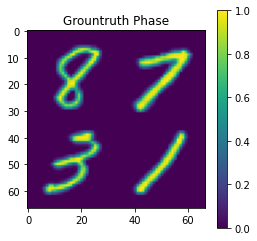

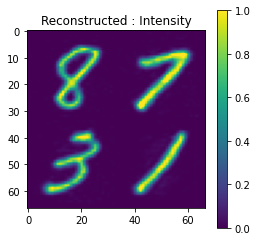

In [6]:
cfg, model, val_loader = initiate_model('MNIST')
inference(cfg, model, val_loader)

#### HeLa [0, $\pi$]

No learnable transmission coefficients
Learnable transmission coefficient: Amplitude and Phase
Learnable transmission coefficient: Amplitude and Phase
Learnable transmission coefficient: Amplitude and Phase
Learnable transmission coefficient: Amplitude and Phase
Learnable transmission coefficient: Amplitude and Phase
Learnable transmission coefficient: Amplitude and Phase
Learnable transmission coefficient: Amplitude and Phase
Learnable transmission coefficient: Amplitude and Phase
get_qpm_np_dataloaders
68
Mean SSIM =  0.625355923000504


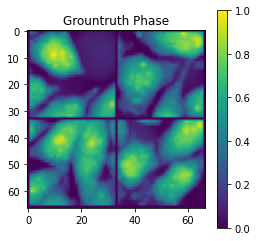

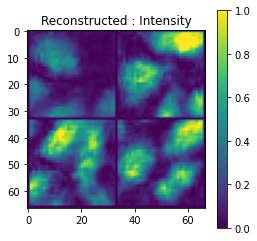

In [7]:
cfg, model, val_loader = initiate_model('HeLa [0,Pi]')
inference(cfg, model, val_loader)

#### HeLa [0, $2\pi$]

No learnable transmission coefficients
Learnable transmission coefficient: Amplitude and Phase
Learnable transmission coefficient: Amplitude and Phase
Learnable transmission coefficient: Amplitude and Phase
Learnable transmission coefficient: Amplitude and Phase
Learnable transmission coefficient: Amplitude and Phase
Learnable transmission coefficient: Amplitude and Phase
Learnable transmission coefficient: Amplitude and Phase
Learnable transmission coefficient: Amplitude and Phase
get_qpm_np_dataloaders
68
Mean SSIM =  0.4853629509315771


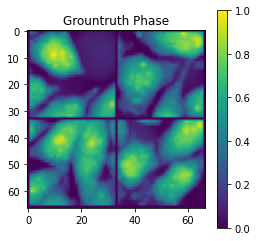

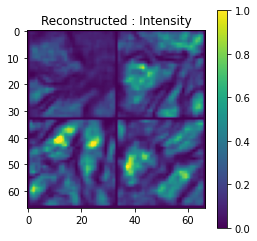

In [8]:
cfg, model, val_loader = initiate_model('HeLa [0,2Pi]')
inference(cfg, model, val_loader)

### Bacteria

No learnable transmission coefficients
Learnable transmission coefficient: Amplitude and Phase
Learnable transmission coefficient: Amplitude and Phase
Learnable transmission coefficient: Amplitude and Phase
Learnable transmission coefficient: Amplitude and Phase
Learnable transmission coefficient: Amplitude and Phase
Learnable transmission coefficient: Amplitude and Phase
Learnable transmission coefficient: Amplitude and Phase
Learnable transmission coefficient: Amplitude and Phase
get_bacteria_dataloaders
494
Mean SSIM =  0.9934533515922453


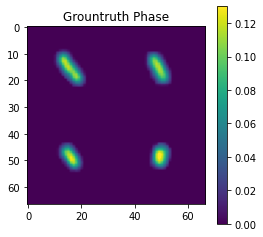

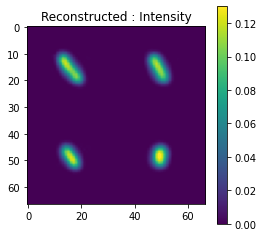

In [9]:
cfg, model, val_loader = initiate_model('Bacteria')
inference(cfg, model, val_loader)